In [1]:
import os
import sys
import random
import datetime
import time
import shutil
import argparse
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import math
from skimage.measure import compare_ssim as sk_ssim

import torch
from torch import nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributed as dist
import torch.utils.data.distributed
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils

import model, dataset, utilities

In [2]:
Input = pd.read_csv('inputs.txt').set_index('Wavelength').T.values
Output = pd.read_csv('outputs.txt').set_index('Wavelength').T.values

In [3]:
spectra_num = len(Input)

train_split = round(0.9 * spectra_num)
test_split = round(0.1 * spectra_num)

input_train = Input[:train_split]
input_test = Input[train_split:train_split+test_split]

output_train = Output[:train_split]
output_test = Output[train_split:train_split+test_split]

In [4]:
Raman_Dataset_Train = dataset.RamanDataset(input_train, output_train, batch_size = 30, spectrum_len = 1024,
                                   spectrum_shift=0, spectrum_window = False, horizontal_flip = False, mixup = False)

Raman_Dataset_Test = dataset.RamanDataset(input_test, output_test, batch_size = 10, spectrum_len = 1024)

train_loader = DataLoader(Raman_Dataset_Train, batch_size = 30, shuffle = False, num_workers = 0, pin_memory = True)
test_loader = DataLoader(Raman_Dataset_Test, batch_size = 10, shuffle = False, num_workers = 0, pin_memory = True)

In [5]:
net = model.ResUNet(3,'store_true').float()

In [6]:
criterion = nn.L1Loss()
criterion_MSE = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr = 5e-4)
scheduler = None

In [7]:
def train(dataloader, net, optimizer, scheduler, criterion, criterion_MSE, epoch):
    
    batch_time = utilities.AverageMeter('Time', ':6.3f')
    losses = utilities.AverageMeter('Loss', ':.4e')
    progress = utilities.ProgressMeter(len(dataloader), [batch_time, losses], prefix="Epoch: [{}]".format(epoch))

    end = time.time()
    for i, data in enumerate(dataloader):
        inputs = data['input_spectrum']
        inputs = inputs.float()
        #inputs = inputs.cuda(args.gpu)
        target = data['output_spectrum']
        target = target.float()
        #target = target.cuda(args.gpu)

        output = net(inputs)

        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step() 

        loss_MSE = criterion_MSE(output, target)
        losses.update(loss_MSE.item(), inputs.size(0)) 

        batch_time.update(time.time() - end)
        end = time.time()

        if i % 400 == 0:
            progress.display(i)
            
    return losses.avg

In [8]:
sg_parameters = [(3,1),(5,1),(7,1),(9,1),(3,2),(5,2),(7,2),(9,2),(5,3),(7,3),(9,3),(11,3)]
sg_index = 3

def evaluate(dataloader, net):
    
    losses = utilities.AverageMeter('Loss', ':.4e')
    SG_loss = utilities.AverageMeter('Savitzky-Golay Loss', ':.4e')
    raw_losses = utilities.AverageMeter('Raw Loss', ':.4e')

    net.eval()
    
    MSE_SG = []

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            x = data['input_spectrum']
            inputs = x.float()
            #inputs = inputs.cuda(args.gpu)
            y = data['output_spectrum']
            target = y.float()
            #target = target.cuda(args.gpu)
            
            x = np.squeeze(x.numpy())
            y = np.squeeze(y.numpy())

            output = net(inputs)
            loss = nn.MSELoss()(output, target)
            raw_loss = nn.MSELoss()(inputs, target)
            
            x_out = output.cpu().detach().numpy()
            x_out = np.squeeze(x_out)

            #Savitzky-Golay
            
            for par in sg_parameters:
            
                SGF = scipy.signal.savgol_filter(x,par[0],par[1])
                MSE_SGF = np.mean(np.mean(np.square(np.absolute(y - (SGF - np.reshape(np.amin(SGF, axis = 1), (len(SGF),1)))))))
                MSE_SG.append(MSE_SGF)
            
            losses.update(loss.item(), inputs.size(0))
            raw_losses.update(raw_loss.item(), inputs.size(0))


        MSE_SG = np.reshape(MSE_SG,(-1,len(sg_parameters)))    
        
        print("Raw MSE: {}".format(raw_losses.avg))
        print("Neural Network MSE: {}".format(losses.avg))
        print("Savitzky-Golay MSE: {}".format(np.mean(np.asarray(MSE_SG[:,sg_index]))))
        print("Neural Network performed {0:.2f}x better than Savitzky-Golay".format(np.mean(np.asarray(MSE_SG[:,sg_index]))/losses.avg))

    return raw_losses.avg, losses.avg, MSE_SG, x,y,output

In [9]:
#DATE = datetime.datetime.now().strftime("%Y_%m_%d")
#models_dir = "{}_{}_{}.pt".format(DATE, optimizer, scheduler)

for epoch in range(100):
    train_loss = train(train_loader, net, optimizer, scheduler, criterion, criterion_MSE, epoch)

#torch.save(net.state_dict(), models_dir)
print('Finished Training')

Epoch: [0][0/3]	Time  7.327 ( 7.327)	Loss 3.2253e-02 (3.2253e-02)
Epoch: [1][0/3]	Time  1.546 ( 1.546)	Loss 1.4482e-02 (1.4482e-02)
Epoch: [2][0/3]	Time  0.670 ( 0.670)	Loss 8.7843e-03 (8.7843e-03)
Epoch: [3][0/3]	Time  0.556 ( 0.556)	Loss 6.5093e-03 (6.5093e-03)
Epoch: [4][0/3]	Time  0.730 ( 0.730)	Loss 4.0521e-03 (4.0521e-03)
Epoch: [5][0/3]	Time  0.781 ( 0.781)	Loss 3.1342e-03 (3.1342e-03)
Epoch: [6][0/3]	Time  0.611 ( 0.611)	Loss 3.6005e-03 (3.6005e-03)
Epoch: [7][0/3]	Time  0.676 ( 0.676)	Loss 2.6129e-03 (2.6129e-03)
Epoch: [8][0/3]	Time  0.564 ( 0.564)	Loss 2.4934e-03 (2.4934e-03)
Epoch: [9][0/3]	Time  0.644 ( 0.644)	Loss 2.5038e-03 (2.5038e-03)
Epoch: [10][0/3]	Time  0.506 ( 0.506)	Loss 2.3685e-03 (2.3685e-03)
Epoch: [11][0/3]	Time  0.652 ( 0.652)	Loss 2.1919e-03 (2.1919e-03)
Epoch: [12][0/3]	Time  0.587 ( 0.587)	Loss 2.1479e-03 (2.1479e-03)
Epoch: [13][0/3]	Time  0.523 ( 0.523)	Loss 2.0840e-03 (2.0840e-03)
Epoch: [14][0/3]	Time  0.543 ( 0.543)	Loss 2.0660e-03 (2.0660e-03)
Epoch

In [13]:
MSE_raw, MSE_NN, MSE_SG, x, y, output = evaluate(test_loader, net)

Raw MSE: 0.03927547484636307
Neural Network MSE: 0.005129403900355101
Savitzky-Golay MSE: 0.022078253822288084
Neural Network performed 4.30x better than Savitzky-Golay


In [14]:
MSE = [MSE_raw,MSE_NN]
MSE = np.concatenate((MSE,MSE_SG[0]))

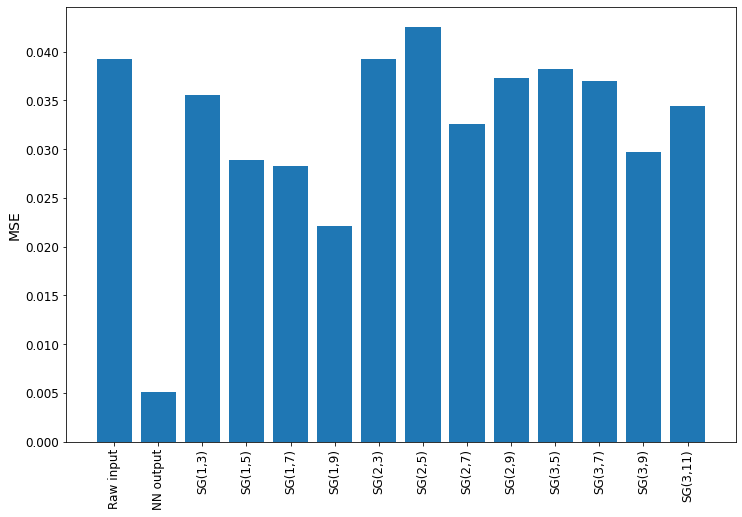

In [23]:
fig = plt.figure(figsize=(12,8))
labels = ['Raw input', 'NN output', 'SG(1,3)', 'SG(1,5)', 'SG(1,7)', 'SG(1,9)', 'SG(2,3)', 'SG(2,5)', 'SG(2,7)', 'SG(2,9)', 'SG(3,5)', 'SG(3,7)', 'SG(3,9)', 'SG(3,11)']
plt.bar(labels,MSE)
plt.xticks(rotation='vertical',fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('MSE',fontsize=14)
plt.show()
fig.savefig('errorbars.png')

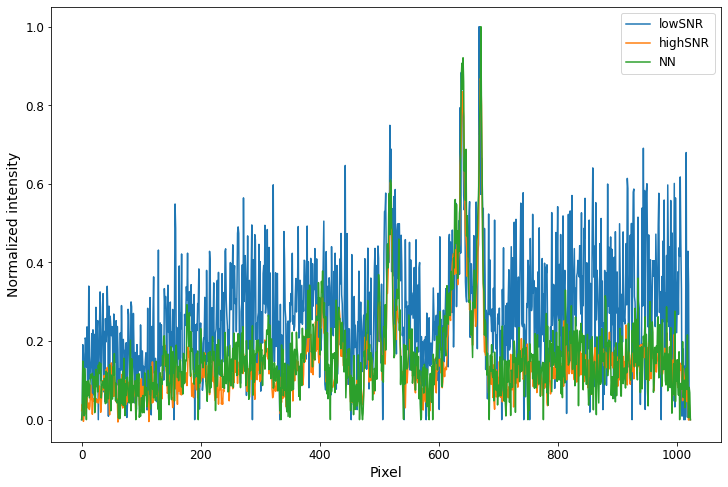

In [54]:
input_spec = x[0]
output_spec = output.numpy()[0][0]
target_spec = y[0]

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
axes.plot(input_spec,label='lowSNR')
axes.plot(output_spec,label='highSNR')
axes.plot(target_spec,label='NN')
axes.legend(fontsize=12)
axes.set_xlabel('Pixel',fontsize=14)
axes.set_ylabel('Normalized intensity',fontsize=14)
axes.tick_params('both',labelsize=12)